In [1]:
%%capture
!pip install Biopython
!rm -r iFeature
!git clone https://github.com/Superzchen/iFeature
!git clone https://github.com/nicolagulmini/virulent_factor_classification.git
!pip install visualkeras

import numpy
import tensorflow
from tensorflow import keras
import matplotlib.pyplot as plt
from Bio import SeqIO

numpy.random.seed(42)

### Following [this](https://doi.org/10.1093/bib/bbv082) on dataset preparation a treshold of 60% identity have been chosen for a clustering with [CD-hit](http://weizhong-lab.ucsd.edu/cdhit-web-server/cgi-bin/index.cgi?cmd=cd-hit) 

In [2]:
'''
# parse CD-Hit data
infile = open('virulent_factor_classification/new_datasets_cleaned/pos_fasta_60', 'r').readlines()
pos_ids = []
for element in str(infile).split('>'):
    for seq in element.split('\n'):
        if '*' in seq:
            pos_ids.append(seq.split('|')[0][:-3])
infile = open('virulent_factor_classification/new_datasets_cleaned/neg_fasta_60', 'r').readlines()
neg_ids = []
for element in str(infile).split('>'):
    for seq in element.split('\n'):
        if '*' in seq:
            neg_ids.append(seq.split('|')[1])

print(len(neg_ids))
print(len(pos_ids))

limit = min(len(neg_ids), len(pos_ids))

# clean sequence data
pos_seqs = list(SeqIO.parse('./virulent_factor_classification/new_datasets/positive/pos.fasta', 'fasta'))
cleaned_pos_seqs = [entry for entry in pos_seqs if str(entry.id.split('(')[0]) in str(pos_ids)]

neg_seqs = list(SeqIO.parse('./virulent_factor_classification/new_datasets/negative/neg.fasta', 'fasta'))
cleaned_neg_seqs = [entry for entry in neg_seqs if str(entry.id.split('|')[1]) in str(neg_ids)]

# match lengths
cleaned_pos_seqs = cleaned_pos_seqs[:limit] 
cleaned_neg_seqs = cleaned_neg_seqs[:limit]
print('len of pos dataset:', len(cleaned_pos_seqs))
print('len of neg dataset:', len(cleaned_neg_seqs))

# rewrite fasta files
def writer(fasta_list, outfile_name):
    outfile = open(outfile_name, 'w')
    for entry in fasta_list:
        outfile.write('>'+str(entry.id)+'\n')
        outfile.write(str(entry.seq)+'\n')

writer(cleaned_pos_seqs, 'cleaned_pos.fasta')
writer(cleaned_neg_seqs, 'cleaned_neg.fasta')
'''
# already done

"\n# parse CD-Hit data\ninfile = open('virulent_factor_classification/new_datasets_cleaned/pos_fasta_60', 'r').readlines()\npos_ids = []\nfor element in str(infile).split('>'):\n    for seq in element.split('\n'):\n        if '*' in seq:\n            pos_ids.append(seq.split('|')[0][:-3])\ninfile = open('virulent_factor_classification/new_datasets_cleaned/neg_fasta_60', 'r').readlines()\nneg_ids = []\nfor element in str(infile).split('>'):\n    for seq in element.split('\n'):\n        if '*' in seq:\n            neg_ids.append(seq.split('|')[1])\n\nprint(len(neg_ids))\nprint(len(pos_ids))\n\nlimit = min(len(neg_ids), len(pos_ids))\n\n# clean sequence data\npos_seqs = list(SeqIO.parse('./virulent_factor_classification/new_datasets/positive/pos.fasta', 'fasta'))\ncleaned_pos_seqs = [entry for entry in pos_seqs if str(entry.id.split('(')[0]) in str(pos_ids)]\n\nneg_seqs = list(SeqIO.parse('./virulent_factor_classification/new_datasets/negative/neg.fasta', 'fasta'))\ncleaned_neg_seqs = [en

Now, remove antigens from datasets in order to overcome NERVE overfitting

In [3]:
# Remove proteins with over 60% 

# Pipeline

In [4]:
'''
!python iFeature/iFeature.py --file ./virulent_factor_classification/data/25_similarity/pos_25.fasta --type AAC --out aac_cleaned_pos.out    # amino acids composition
!python iFeature/iFeature.py --file ./virulent_factor_classification/data/25_similarity/pos_25.fasta --type DPC --out dpc_cleaned_pos.out    # dipeptide composition
!python iFeature/iFeature.py --file ./virulent_factor_classification/data/25_similarity/pos_25.fasta --type CTDC --out ctdc_cleaned_pos.out  # composition
!python iFeature/iFeature.py --file ./virulent_factor_classification/data/25_similarity/pos_25.fasta --type CTDT --out ctdt_cleaned_pos.out  # transition
!python iFeature/iFeature.py --file ./virulent_factor_classification/data/25_similarity/pos_25.fasta --type CTDD --out ctdd_cleaned_pos.out  # distribution

print("pos: DONE!")

!python iFeature/iFeature.py --file ./virulent_factor_classification/data/25_similarity/neg_25.fasta --type AAC --out aac_cleaned_neg.out    # amino acids composition
!python iFeature/iFeature.py --file ./virulent_factor_classification/data/25_similarity/neg_25.fasta --type DPC --out dpc_cleaned_neg.out    # dipeptide composition
!python iFeature/iFeature.py --file ./virulent_factor_classification/data/25_similarity/neg_25.fasta --type CTDC --out ctdc_cleaned_neg.out  # composition
!python iFeature/iFeature.py --file ./virulent_factor_classification/data/25_similarity/neg_25.fasta --type CTDT --out ctdt_cleaned_neg.out  # transition
!python iFeature/iFeature.py --file ./virulent_factor_classification/data/25_similarity/neg_25.fasta --type CTDD --out ctdd_cleaned_neg.out  # distribution

print("neg: DONE!")
'''
# already done

'\n!python iFeature/iFeature.py --file ./virulent_factor_classification/data/25_similarity/pos_25.fasta --type AAC --out aac_cleaned_pos.out    # amino acids composition\n!python iFeature/iFeature.py --file ./virulent_factor_classification/data/25_similarity/pos_25.fasta --type DPC --out dpc_cleaned_pos.out    # dipeptide composition\n!python iFeature/iFeature.py --file ./virulent_factor_classification/data/25_similarity/pos_25.fasta --type CTDC --out ctdc_cleaned_pos.out  # composition\n!python iFeature/iFeature.py --file ./virulent_factor_classification/data/25_similarity/pos_25.fasta --type CTDT --out ctdt_cleaned_pos.out  # transition\n!python iFeature/iFeature.py --file ./virulent_factor_classification/data/25_similarity/pos_25.fasta --type CTDD --out ctdd_cleaned_pos.out  # distribution\n\nprint("pos: DONE!")\n\n!python iFeature/iFeature.py --file ./virulent_factor_classification/data/25_similarity/neg_25.fasta --type AAC --out aac_cleaned_neg.out    # amino acids composition\n!p

In [5]:
def from_files_to_vectors(fasta_path, positive=True):
    if positive:
        proteins = list(SeqIO.parse(fasta_path+'pos_25.fasta', "fasta"))
    else:
        proteins = list(SeqIO.parse(fasta_path+'neg_25.fasta', "fasta"))
    extension = ".out"
    files = ["aac", "dpc", "ctdc", "ctdt", "ctdd"]
    if positive:
        names = "_cleaned_pos"
    else:
        names = "_cleaned_neg"
    for i in range(len(files)):
        files[i] += names
    datasets = [[] for el in files]
    for i in range(len(files)):
        with open(fasta_path+files[i]+extension) as f:
            lines = f.readlines()[1:]
            check_prot = 0
            for line in lines:
                information = line.split('\t')
                if not information[0] == proteins[check_prot].id:
                    print("Error in protein order! Return")
                    return datasets
                datasets[i].append(numpy.array([float(el) for el in information[1:]]))
                check_prot += 1
        datasets[i] = numpy.array(datasets[i])
    return datasets

In [6]:
pos_datasets = from_files_to_vectors("./virulent_factor_classification/data/25_similarity/pos/", positive=True)
neg_datasets = from_files_to_vectors("./virulent_factor_classification/data/25_similarity/neg/", positive=False)

y_pos = numpy.ones(pos_datasets[0].shape[0])
y_neg = numpy.zeros(neg_datasets[0].shape[0])

In [7]:
# attach datasets in order to obtain a matrix of (n, 20+400+39+39+195) features

# keep in mind the number of virulent factors and the number of not virulent factors
rows = 0
n_pos = y_pos.shape[0]
n_neg = y_neg.shape[0]
rows = n_pos + n_neg
print('Virulent:', n_pos)
print('NON Virulent:', n_neg)

# feature vectors dimensions
columns = 0
for i in range(len(pos_datasets)):
    tmp_dim = pos_datasets[i].shape[1]
    print(i+1, '-th feature dim:', tmp_dim)
    columns += tmp_dim

# data matrix to process
X = numpy.zeros((rows, columns))
print('Data matrix dimension:', X.shape)
for i in range(n_pos):
    X[i] = numpy.concatenate([pos_datasets[j][i] for j in range(5)])
for i in range(n_neg):
    X[n_pos+i] = numpy.concatenate([neg_datasets[j][i] for j in range(5)])

Virulent: 2163
NON Virulent: 1833
1 -th feature dim: 20
2 -th feature dim: 400
3 -th feature dim: 39
4 -th feature dim: 39
5 -th feature dim: 195
Data matrix dimension: (3996, 693)


In [8]:
# permutation
y = numpy.concatenate((y_pos, y_neg), axis=0)
c = numpy.random.permutation(numpy.arange(y.shape[0]))
y = y[c]
X = X[c] 

In [9]:
# remember: standardization or scaling AFTER train-test split, otherwise there's data leakage!!!
X_train = X[:int(X.shape[0]*.5)]
X_val = X[int(X.shape[0]*.5):int(X.shape[0]*.75)]
X_test = X[int(X.shape[0]*.75):]

y_train = y[:int(y.shape[0]*.5)]
y_val = y[int(y.shape[0]*.5):int(y.shape[0]*.75)]
y_test = y[int(y.shape[0]*.75):]

print('Training data shape:', X_train.shape, y_train.shape)
print('Validation data shape:', X_val.shape, y_val.shape)
print('Test data shape:', X_test.shape, y_test.shape)

print('\nTraining virulent factors and not-virulent factors:', int(sum(y_train)), int(y_train.shape[0]-sum(y_train)))
print('Validation virulent factors and not-virulent factors:', int(sum(y_val)), int(y_val.shape[0]-sum(y_val)))
print('Test virulent factors and not-virulent factors:', int(sum(y_test)), int(y_test.shape[0]-sum(y_test)))

Training data shape: (1998, 693) (1998,)
Validation data shape: (999, 693) (999,)
Test data shape: (999, 693) (999,)

Training virulent factors and not-virulent factors: 1090 908
Validation virulent factors and not-virulent factors: 544 455
Test virulent factors and not-virulent factors: 529 470


In [10]:
# PCA

stdX = numpy.zeros(X_train.shape)
stdX_val = numpy.zeros(X_val.shape)
stdX_test = numpy.zeros(X_test.shape)

means = numpy.zeros(X_train.shape[1])
std_devs = numpy.zeros(X_train.shape[1])

for j in range(X_train.shape[1]):
    column = X_train[:,j]
    means[j] = numpy.mean(column)
    std_devs[j] = numpy.std(column)
    stdX[:,j] = (column - means[j]) / std_devs[j]
    stdX_val[:,j] = (X_val[:,j] - means[j]) / std_devs[j]
    stdX_test[:,j] = (X_test[:,j] - means[j]) / std_devs[j]

numpy.save('means', means)
numpy.save('std_devs', std_devs)

covariance_matrix = numpy.cov(stdX.T)

eigen_values, eigen_vectors = numpy.linalg.eig(covariance_matrix)
eigen_values = numpy.real(eigen_values)
eigen_vectors = numpy.real(eigen_vectors)

variance_explained = []
for i in eigen_values:
    variance_explained.append((i/sum(eigen_values))*100)

cumulative_variance_explained = numpy.cumsum(variance_explained)

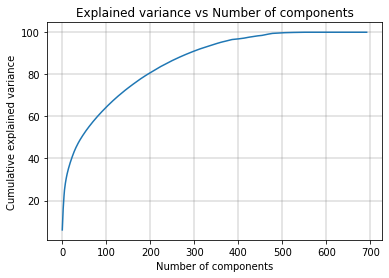

In [11]:
plt.title("Explained variance vs Number of components")

plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.grid(color='gray', linewidth=.4)

plt.plot(range(len(cumulative_variance_explained)), cumulative_variance_explained)

plt.show()
#plt.savefig('Explained variance.png')

In [12]:
K = 400 # more or less like adhesin
print('Principal components:', K)
print('Discarded components:', columns-K)

Principal components: 400
Discarded components: 293


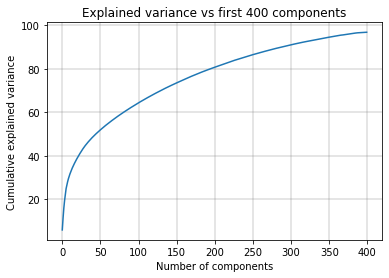

In [13]:
plt.title("Explained variance vs first " + str(K) + " components")

plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.grid(color='gray', linewidth=.4)

plt.plot(range(K), cumulative_variance_explained[:K])

plt.show()
#plt.savefig('Explained variance.png')

In [14]:
# Project using first K components

projection_matrix = numpy.real((eigen_vectors.T[:][:K]).T)
print(projection_matrix.shape)

numpy.save('projection_matrix', projection_matrix)

(693, 400)


In [15]:
# project matrices
X_train = stdX.dot(projection_matrix)
X_val = stdX_val.dot(projection_matrix)
X_test = stdX_test.dot(projection_matrix)

In [16]:
from tensorflow.keras import regularizers

class neural_network:
    def __init__(self):
        input = tensorflow.keras.Input(shape=(K,))

        dense = tensorflow.keras.layers.Dense(units=10, activation='sigmoid')(input) # it shows that a linear activation is sufficiet to get the same accuracy of the sigmoid (so it's like a matrix multiplication with a non-linearity at the end...)
        #batch = tensorflow.keras.layers.BatchNormalization()(dense)
        #activation = tensorflow.keras.activations.sigmoid(batch)
        #drop = tensorflow.keras.layers.Dropout(.1)(activation)

        output = tensorflow.keras.layers.Dense(1, activation='sigmoid')(dense)

        model = tensorflow.keras.models.Model(inputs=input, outputs=output)
        model.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics='accuracy')
        self.model = model

In [17]:
nn = neural_network()

In [18]:
history = nn.model.fit(
    x=X_train, 
    y=y_train,
    batch_size=64,
    epochs=1000,
    verbose=0,
    validation_data=(X_val, y_val),
    shuffle=True,
    callbacks=[tensorflow.keras.callbacks.EarlyStopping(
    restore_best_weights=True,
    patience=20
        )]
)

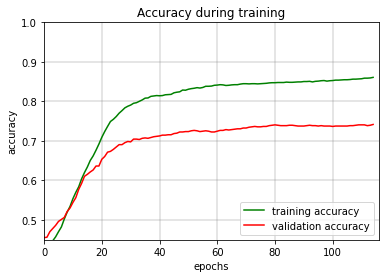

In [19]:
plt.title('Accuracy during training')
plt.plot(range(len(history.history['loss'])), history.history['accuracy'], label='training accuracy', color='green')
plt.plot(range(len(history.history['loss'])), history.history['val_accuracy'], label='validation accuracy', color='red')
plt.grid(color='gray', linewidth=.4)

plt.legend(loc="lower right")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.xlim(0, len(history.history['loss'])+1)
plt.ylim(.45, 1.)
plt.savefig('acc.png')

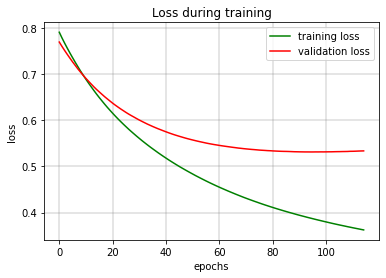

In [20]:
plt.title('Loss during training')
plt.plot(range(len(history.history['loss'])), history.history['loss'], label='training loss', color='green')
plt.plot(range(len(history.history['loss'])), history.history['val_loss'], label='validation loss', color='red')
plt.grid(color='gray', linewidth=.4)

plt.legend(loc="upper right")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.savefig('loss.png')

In [21]:
nn.model.evaluate(x=X_test, y=y_test)

32/32 [==============================] - 0s 2ms/step - loss: 0.5001 - accuracy: 0.7598


[0.5001479387283325, 0.759759783744812]

In [22]:
nn.model.save('vcm.h5')

### Check performace on negative and positive classes

In [23]:
'''
pos_dataset_test = [[] for array in range(len(datasets_test))]
for array in range(len(datasets_test)):
    for item, i in zip(datasets_test[array], y_test):
        if i == 1:
            pos_dataset_test[array].append(list(item))
for i in range(5):
    pos_dataset_test[i]=numpy.array(pos_dataset_test[i])
y_pos_test = numpy.array([1. for _ in range(len(pos_dataset_test[0]))])

neg_dataset_test = [[] for array in range(len(datasets_test))]
for array in range(len(datasets_test)):
    for item, i in zip(datasets_test[array], y_test):
        if i == 0:
            neg_dataset_test[array].append(list(item))
for i in range(5):
    neg_dataset_test[i]=numpy.array(neg_dataset_test[i])
y_neg_test = numpy.array([0. for _ in range(len(neg_dataset_test[0]))])

pos_perf = nn.model.evaluate(x=pos_dataset_test, y=y_pos_test)
neg_perf = nn.model.evaluate(x=neg_dataset_test, y=y_neg_test)
print('Accuracy on POSITIVE classes:', pos_perf[1])
print('Accuracy on NEGATIVE classes:', neg_perf[1])

'''

"\npos_dataset_test = [[] for array in range(len(datasets_test))]\nfor array in range(len(datasets_test)):\n    for item, i in zip(datasets_test[array], y_test):\n        if i == 1:\n            pos_dataset_test[array].append(list(item))\nfor i in range(5):\n    pos_dataset_test[i]=numpy.array(pos_dataset_test[i])\ny_pos_test = numpy.array([1. for _ in range(len(pos_dataset_test[0]))])\n\nneg_dataset_test = [[] for array in range(len(datasets_test))]\nfor array in range(len(datasets_test)):\n    for item, i in zip(datasets_test[array], y_test):\n        if i == 0:\n            neg_dataset_test[array].append(list(item))\nfor i in range(5):\n    neg_dataset_test[i]=numpy.array(neg_dataset_test[i])\ny_neg_test = numpy.array([0. for _ in range(len(neg_dataset_test[0]))])\n\npos_perf = nn.model.evaluate(x=pos_dataset_test, y=y_pos_test)\nneg_perf = nn.model.evaluate(x=neg_dataset_test, y=y_neg_test)\nprint('Accuracy on POSITIVE classes:', pos_perf[1])\nprint('Accuracy on NEGATIVE classes:',